# TUTORIAL: Real-time data assimilation
<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=default'></script>

* [What is real-time data assimilation?](#first)
    * [Sources of uncertainties in the assimilation framework](#second)
    * [Augmented state-space formulation](#third)
* [Bayesian formulation of data assimilation](#fourth)
    * [Example of Bayesian update in an univariate case](#fourth-1)
* [Stochastic ensemble framework: the Ensemble Kalman filter](#fifth)
    * [What is a twin experiment?](#fifth-twin)
    * [Test case: the Van der Pol oscillator](#fifth-vdp)


In [1]:
import parent_folders



# 1. What is real-time data assimilation? <a class="anchor" id="first"></a>


<br />Data assimilation&nbsp;is a technique for combining observational data and numerical models to improve our understanding and prediction of complex physical systems, allowing us to make more accurate forecasts and decisions in a wide range of fields such as meteorology and ocean studies. &#8203;&nbsp;The overarching objective of data assimilation is to make&nbsp;<em>qualitatively</em>&nbsp;accurate numerical models more&nbsp;<em>quantitatively</em>&nbsp;correct.&nbsp;</font><span>The three ingredients for this are (1) a physical model, which provides the states; (2) data, which provide the observables; and (3) a statistical method, which finds the most likely model by assimilating the data in the model.</span><br />

There is a variety of statistical methods in data assimilation, which can be broadly classified into variational (e.g. 4DVar), or sequential methods (e.g. Kalman filters). The choice of method depends on the specific application and the characteristics of the system being studied.&nbsp;Sequential methods are also referred to as <strong>real-time data assimilation</strong> because the observations are processed on-the-fly as soon as they become available. This is an iterative procedure in which observations are continually collected, and the model states and/or parameters are repeatedly adjusted to incorporate the new data. 


The objective is to estimate a physical quantity $\mathbf{d}^\dagger$  (i.e., the <em>truth</em>), which is unknown. For this purpose, real-time data assimilation combines two sources of information on the system on the fly:
</font><ol><li>A physical numerical model, which can be expressed in the state-space formulation $$
\begin{align}
\left\{
\begin{array}{rcl}
\mathrm{d}\boldsymbol{\phi} &=& \mathcal{F}\left(\boldsymbol{\phi}, \boldsymbol{\alpha} \right)\mathrm{d} t,  \\ 
\mathbf{q} &=& \mathcal{M}(\boldsymbol{\phi})
\end{array}\right.
\end{align} $$ where the $\mathcal{F}:\mathbb{R}^{N_\phi}\rightarrow\mathbb{R}^{N_\phi}$ is a function of model parameters $\boldsymbol{\alpha}$ and state variables $\boldsymbol{\phi}$; $\mathbf{q}$ are the model estimates, which are obtained by mapping the state variables into the observable space through the operator $\mathcal{M}(\boldsymbol{\phi})$. 
</li><li>Measurement data $\mathbf{d}$ (e.g., from higher-order models or experiments). The data are also be affected by aleatoric uncertainties  due to environmental and instrumental noise. We assume that the observations are unbiased such that $$
\begin{align}
 \mathbb{E}(\mathbf{d}) &= \mathbf{d}^\dagger, \quad\text{and} \quad\mathbf{d}\sim\mathcal{N}(\mathbf{d}^\dagger, \mathbf{C}_{dd}),
\end{align}
$$
 where $\mathbf{C}_{dd}$ is a predifined measurement error matrix. We assume that the measurements are uncorrelated such that $\mathbf{C}_{dd}$ is a diagonal matrix. </li></ol></div>


In a nutshell, the assimilation&nbsp;process consists of&nbsp; repeating sequentially the following three steps:
</font><ol><li><em>Forecast</em>: propagate the numerical model in time&nbsp;until <strong><font color="#24678d">observation</font></strong> data become available.&nbsp;The&nbsp;model&nbsp;provides an estimate of the observed physical quantity, which is known as the <strong><font color="#e0915c">forecast</font></strong>.
</li><li><em>Analysis</em>:&nbsp;combine <span>optimally</span>the<strong><font color="#e0915c">forecast</font></strong>&nbsp;with the <strong><font color="#24678d">observations</font></strong>. This&nbsp;results in an improved estimate of the physical quantity, which is more accurate than the forecast, and it is&nbsp; known as the <strong><font color="#76cae9">analysis</font></strong>.
</li><li><em>Update</em>: the <strong><font color="#76cae9">analysis</font></strong> state becomes the initial condition for the next forecast step. &#8203;</li></ol></div>
<br />
<a>
<img src="figs/Real-time-DA.gif" alt="Real-time data assimilation schematic" style="width:100%" />
</a>
<div style="display:block;font-size:90%"></div>


<br />

## 1.1. Sources of uncertainties in the assimilation framework <a class="anchor" id="second"></a>

In practice,  physical models are subject to aleatoric uncertainties in either  the nonlinear operator $\mathcal{F}$, due to poorly-known states $\boldsymbol{\phi}$ and/or parameters $\boldsymbol{\alpha}$; or in the measurement operator $\mathcal{M}$, due to e.g., discretization errors, which lead to uncertain estimates in the observable space $\mathbf{q}$. We define the uncertainties in the state variables, $\boldsymbol{\epsilon}_\phi$, in the model parameters, $\boldsymbol{\epsilon}_\alpha$, and in the measurement operator, $\boldsymbol{\epsilon}_q$ such that
\begin{equation}
    \boldsymbol{\phi}  + \boldsymbol{\epsilon}_\phi = \boldsymbol{\phi}^\dagger, \quad
    \boldsymbol{\alpha} + \boldsymbol{\epsilon}_\alpha = \boldsymbol{\alpha}^\dagger , \quad \text{and} \quad 
    \mathbf{q} + \boldsymbol{\epsilon}_q= \mathbf{q}^\dagger, \quad
\end{equation}
where the $\dagger$ indicates the state, parameters and  estimate which provide the best representation of the truth $\mathbf{d}^\dagger$ (which we do not know). 

In this tutorial, we assume that $ \mathbb{E}(\mathbf{q}) = \mathbf{q}^\dagger =  \mathbf{d}^\dagger$, i.e., we assime that the model is unbiased. Further, aleatoric uncertainties are typically modelled as Gaussian stochastic processes, i.e.,  
\begin{equation}
    \boldsymbol{\epsilon}_\phi \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{\phi\phi} ), \quad \boldsymbol{\epsilon}_\alpha \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{\alpha\alpha} ), \quad \text{and} \quad \boldsymbol{\epsilon}_q \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{qq})
\end{equation}
where $\mathcal{N}(\mathbf{0}, \mathbf{C})$ is a normal distribution with zero mean and covariance $\mathbf{C}$. Taking into account the aleatoric errors, we rewrite the model in the stochastic state-space form 
$$
\begin{equation}
\left\{
\begin{array}{rcl}
\mathrm{d} \boldsymbol{\phi}&=&\mathcal{F}\left(\boldsymbol{\phi}+\boldsymbol{\epsilon}_\phi, \boldsymbol{\alpha} +\boldsymbol{\epsilon}_\alpha\right)\mathrm{d} t,  \\
\mathbf{q}&=&\mathcal{M}(\mathbf{x}, \boldsymbol{\phi}) + \boldsymbol{\epsilon}_q, 
\end{array}
\right.
\end{equation}
$$ 
In addition, in a sequential framework, the observation data $\mathbf{d}$ at time $t_k$  are a single realization of the physical quantities of interest subject to uncertainty 
$$
\begin{equation}
    \mathbf{d} + \boldsymbol{\epsilon}_d = \mathbf{d}^\dagger, \quad \text{with} \quad \boldsymbol{\epsilon}_d\sim\mathcal{N}\left(\mathbf{0},\mathbf{C}_{dd}\right),
\end{equation}
$$
where $\mathbf{C}_{dd}$ is pre-defined as a diagonal matrix such that the observations are assumed to be unbiased, uncorrelated, and Gaussian distributed. Thus, the expectation of the observations is the true physical state, i.e. $ \mathbb{E}(\mathbf{d})=\mathbf{d}^\dagger$.
 

<br />

## 1.2. Augmented state-space formulation <a class="anchor" id="third"></a>
Data assimilation updates our knowledge in the model state $\boldsymbol{\phi}$ and the parameters $\boldsymbol{\alpha}$  (i.e., performs state and parameter estimation), by combining the model estimate $\mathbf{q}$ with observations $\mathbf{d}$ when they become available. To perform state and parameter estimation, we reformulate the model by  defining the augmented state vector $\boldsymbol{\psi}=[\boldsymbol{\phi};\boldsymbol{\alpha};\mathbf{q}]$, such that
$$
\begin{align}
\left\{
\begin{array}{rcl}
     \mathrm{d}\begin{bmatrix}
     \boldsymbol{\phi}\\
     \boldsymbol{\alpha}\\
     \mathbf{q}
 \end{bmatrix} &=& 
 \begin{bmatrix}
     \mathcal{F}(\boldsymbol{\phi}+\boldsymbol{\epsilon}_\phi,\boldsymbol{\alpha}+\boldsymbol{\epsilon}_\alpha)\\
     \mathbf{0}_{N_\alpha}\\
     \mathbf{0}_{N_q}
 \end{bmatrix} 
{\mathrm{d} t}  \\
\mathbf{q} &=& \mathcal{M}(\boldsymbol{\phi}, \mathbf{x})  + \boldsymbol{\epsilon}_{q}
\end{array}
\right.
\quad\leftrightarrow  \quad
\left\{
\begin{array}{rcl}
\mathrm{d}\boldsymbol{\psi} &=& \mathbf{F}\left(\boldsymbol{\psi} +\boldsymbol{\epsilon}_\psi\right){\mathrm{d} t}  \\
\mathbf{q} &=& \mathbf{M}\mathbf{\psi}  + \boldsymbol{\epsilon}_{q}
\end{array}
\right.
\end{align}
$$ where $\mathbf{F}$ and $\boldsymbol{\epsilon}_\psi$ are the augmented nonlinear operator and aleatoric uncertainties, respectively; $\mathbf{M} = \left[\mathbf{0}~\big|~\mathbb{I}_{N_q}\right]$ is the linear measurement operator, which consists of the vertical concatenation of a matrix of zeros, and the identity matrix. The augmented formulation yields a linear measurement operator, which is convenient for the formulation of data assimilation methods.



# 2. Bayesian formulation of data assimilation <a class="anchor" id="fourth"></a>
In a Bayesian framework, we quantify our confidence in a model by a probability measure.  We update our confidence in the model predictions every time we have reference data from observations in a real-time framework. The underlying assumption in real-time DA is that the dynamical system is  Markovian, such that the state at a time $t_k$ is only dependent on the previous time  $t_{k-1}$. The Markovian framework simplifies the design of the Bayesian update. Our knowledge in a Markovian model state and observations  are quantified by the conditional probabilities
$$
\begin{equation}
\boldsymbol{\psi}_k \sim \mathcal{P}(\boldsymbol{\psi}_k | \boldsymbol{\psi}_{k-1}, \mathbf{F})\qquad 
\mathbf{d}_k \sim \mathcal{P}(\mathbf{d}_k | \boldsymbol{\psi}_{k},  \mathbf{F}), 
\end{equation} 
$$
where $\mathcal{P}(\cdot|\cdot)$ denotes the conditional probability in which the quantity on the left is conditioned on the knowledge of the quantities on the right.


We updated the knowledge of the system every time at which we have reference data from observations $\mathbf{d}_k$ by using the Bayes' rule, which is central to data assimilation 
$$
\begin{align}
\mathcal{P}(\boldsymbol{\psi}_k | \mathbf{d}_k,\mathbf{F}) = \frac{\mathcal{P}(\mathbf{d}_k | \boldsymbol{\psi}_k,  \mathbf{F}) \mathcal{P}(\boldsymbol{\psi}_k, \mathbf{F})}{\mathcal{P}(\mathbf{d}_k,  \mathbf{F})}, \quad \text{i.e.,} \quad
\texttt{posterior} = \dfrac{\texttt{prior}
\,\times\,
\texttt{likelihood}}
{\texttt{evidence}} 
\end{align}
$$
We select the most probable value  (the mode) of $\boldsymbol{\psi}_k$ in the posterior as the best estimator of the state, i.e., the analysis. This is the <em >maximum a posteriori </em>  approach, which is a well-posed approach in inverse problems.



While technically simple, the Bayes' rule becomes expensive to compute in high dimensions because the prior involves multidimensional integrals (Chapman-Kolmogorov equation). However, we are often interested in capturing only the first and second statistical moments of the probability density function (PDF). We assume that the prior and likelihood are normally-distributed because (i) in this scenario the Gaussian distribution maximizes the entropy, and (2) the posterior given Gaussian prior and likelihood is also a Gaussian.

<br />

## 2.1 Example of Bayesian update in an univariate case

In [2]:
%matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# #
# from scipy import linalg

In [3]:
import numpy as np    
from scipy import stats, linalg

x_grid = np.linspace(-10, 10, 101)

def pdf_Normal(mu, std):
    return stats.norm.pdf(x_grid, loc=mu, scale=std)

def Bayes_rule(prior, likelihood):
    posterior = prior * likelihood       
    return posterior / (np.sum(posterior) * (x_grid[1] - x_grid[0]))


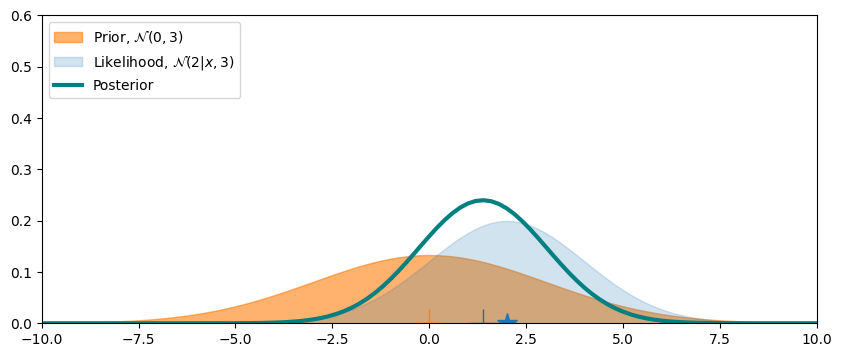

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Initialise prior
prior_mu, prior_std = 0, 3
prior_vals = pdf_Normal(mu=prior_mu, std=prior_std)
plt.fill_between(x_grid, prior_vals,  color='tab:orange', alpha=0.6, label='Prior, $\mathcal{N}$'+f'$({prior_mu}, {prior_std})$')
plt.plot(x_grid[np.argmax(prior_vals)], 0, '+', markersize=20, color='tab:orange')

# Initialise likelihood
def likelihood_func(observation, method=pdf_Normal, likelihood_std=2):
    return method(mu=observation, std=likelihood_std)


# Observe a data point d and compute the posterior
d = 2
likelihood_vals = likelihood_func(observation=d)           
plt.fill_between(x_grid, likelihood_vals, color='tab:blue', alpha=0.2,  label='Likelihood, $\mathcal{N}$'+f'$({d}|x, {prior_std})$')
plt.plot(d, 0, '*', markersize=15, color='tab:blue')

# Compute the new posterior
posterior_vals = Bayes_rule(prior_vals, likelihood_vals)

plt.plot(x_grid, posterior_vals,  color='teal', lw=3 ,label='Posterior')
plt.plot(x_grid[np.argmax(posterior_vals)], 0, '+', markersize=20, color='teal')
plt.gca().set(ylim=(0, 0.6), xlim=(-10, 10))
plt.legend(loc="upper left")




<br />

___

#### Exercise
<em><font color=#7CB9E8>  What happens if the variance of the prior is small? What if the prior or likelihood functions are not Gaussian?


___


We can perform this update sequentially, using the posterior as the new prior:

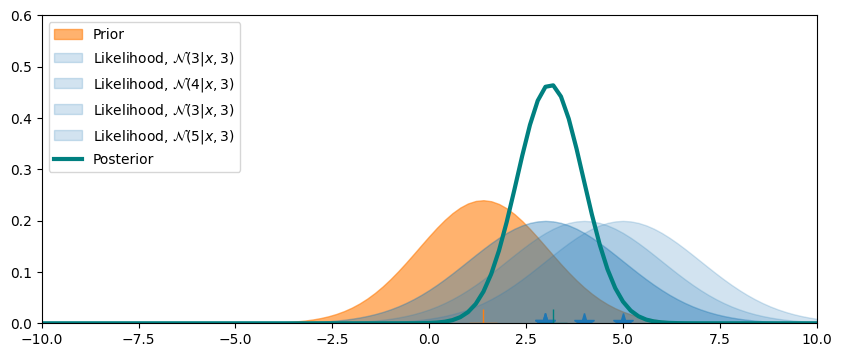

In [5]:

plt.figure(figsize=(10, 4))
plt.fill_between(x_grid, posterior_vals,  color='tab:orange', alpha=0.6, label='Prior') # Use the posterior as the new prior
plt.plot(x_grid[np.argmax(posterior_vals)], 0, '+', markersize=20, color='tab:orange')

observation_stream = [3,4,3,5]
for d in observation_stream:
    prior_vals = posterior_vals                                 # Use the posterior as the new prior
    likelihood_vals = likelihood_func(observation=d)            # Compute the likelihood od the observation
    posterior_vals = Bayes_rule(prior_vals, likelihood_vals)    # Compute the new posterior
    plt.fill_between(x_grid, likelihood_vals, color='tab:blue', alpha=0.2,  label='Likelihood, $\mathcal{N}$'+f'$({d}|x, {prior_std})$')
    plt.plot(d, 0, '*', markersize=15, color='tab:blue')
    

# Plot the final posterior after processing all the observation stream
plt.plot(x_grid, posterior_vals,  color='teal', lw=3,label='Posterior')
plt.plot(x_grid[np.argmax(posterior_vals)], 0, '+', markersize=20, color='teal')
plt.gca().set(ylim=(0, 0.6), xlim=(-10, 10))
plt.legend(loc="upper left");




<br />

___


####  Exercise
<em> <font color=#7CB9E8> <em>
Given Gaussian prior $\boldsymbol{\psi} \sim \mathcal{N}(\boldsymbol{\psi}, \mathbf{C}_{\psi\psi})$ and a likelihood $
\mathbf{d}|\boldsymbol{\psi}) \sim \mathcal{N}(\mathbf{d}, \mathbf{C}_{dd})$,  show that the posterior is also a Gaussian. Hint: the  probability density function of a Gaussian distribution of mean $\boldsymbol{\mu}$ and covariance $\mathbf{C}$ is
$$
f(\boldsymbol{\psi}) = \dfrac{1}{\sqrt{(2\pi)^k |\mathbf{C}|}}\exp\left(-\frac{1}{2} \left(\boldsymbol{\psi} - \boldsymbol{\mu}\right)^\mathrm{T} \mathbf{C}^{-1} \left(\boldsymbol{\psi} - \boldsymbol{\mu}\right)\right)
$$ </em>


<br />

___



<br /> 

# 3. Stochastic ensemble filtering: the Ensemble Kalman filter <a class="anchor" id="fifth"></a>

Under the Gaussian assumption, the inverse problem of finding the states, $\boldsymbol{\phi}$, and parameters, $\boldsymbol{\alpha}$, given some observations, $\mathbf{d}$, would be solved by the Kalman filter equations if the operator $\mathcal{F}$ were linear. Stochastic ensemble data assimilation methods can be used for nonlinear dynamics because they do not require to propagate the covariance, in contrast to other sequential methods, e.g., the extended Kalman filter.  Stochastic ensemble filters track in time $m$-realizations of the augmented state to estimate the mean and covariance, respectively 
$$
\begin{align}
	 \mathbb{E}(\boldsymbol{\psi})\approx\bar{\boldsymbol{\psi}}=\dfrac{1}{m}\sum^m_{j=1}{\boldsymbol{\psi}_j} 
	  \quad \text{and} \quad
	 \mathbf{C}_{\psi\psi} = \begin{bmatrix}
				\mathbf{C}_{\phi\phi}  & \mathbf{C}_{\phi\alpha}& \mathbf{C}_{\phi q} \\
				\mathbf{C}_{\alpha \phi}  & \mathbf{C}_{\alpha\alpha}& \mathbf{C}_{\alpha q} \\
				\mathbf{C}_{q \phi}  & \mathbf{C}_{q \alpha}& \mathbf{C}_{q q} \\
			\end{bmatrix}
			\approx\dfrac{1}{m-1}\sum^m_{j=1}(\boldsymbol{\psi}_i-\bar{\boldsymbol{\psi}})\otimes(\boldsymbol{\psi}_i-\bar{\boldsymbol{\psi}}). 
\end{align}
$$
Each ensemble member $j$ is forecast independently in time with $\mathbf{F}(\boldsymbol{\psi}_j)$ to obtain an ensemble of forecast states $\boldsymbol{\psi}_j^\text{f}$. When a sensor provides noisy data $\mathbf{d}$,  real-time data assimilation statistically combines the noisy data and the forecast ensemble to improve our knowledge in the system's parameters and states (i.e., to compute an analysis ensemble $\boldsymbol{\psi}_j^\mathrm{a}$). Mathematically, we aim to minimize the cost function
$$
\begin{align}
\mathcal{J}(\boldsymbol{\psi}_j) = &\left\|\boldsymbol{\psi}_j-\boldsymbol{\psi}_j^\mathrm{f}\right\|^2_{\mathbf{C}^{\mathrm{f}^{-1}}_{\psi\psi}} +
 \left\|{\boldsymbol{y}}_j-\boldsymbol{d}_j\right\|^2_{\mathbf{C}^{-1}_{dd}}, \quad \mathrm{for} \quad j=0,\dots,m-1,
\end{align}
$$
where $\left\|\cdot\right\|^2_{\mathbf{C}^{-1}}$ is the L2-norm weighted by the semi-positive definite matrix $\mathbf{C}^{-1}$. The ensemble Kalman filter (EnKF) minimize the cost function to obtain an analysis ensemble $\boldsymbol{\psi}_j^\mathrm{a}$ from the forecast ensemble $ \boldsymbol{\psi}_j^\mathrm{f}$ and the observations $\mathbf{d}$ as
$$
\begin{align}
    \boldsymbol{\psi}_j^\mathrm{a} 
    &= \boldsymbol{\psi}_j^\mathrm{f}+\mathbf{K}\left[\mathbf{d}_j - \mathbf{M}\boldsymbol{\psi}_j^\mathrm{f}\right], \quad j=0,\dots,m-1,
\end{align}
$$
where $\mathbf{K}=\mathbf{C}_{\psi\psi}^\mathrm{f}\mathbf{M}^\mathrm{T}\left(\mathbf{C}_{dd}+\mathbf{M}\mathbf{C}_{\psi\psi}^\mathrm{f}\mathbf{M}^\mathrm{T}\right)^{-1}$ is the Kalman gain matrix.  
 
</p>

<br />

## 3.1 What is a twin experiment? <a class="anchor" id="fifth-twin"></a>

In real scenarios, we do not have access to the truth, thus we do not know which are the optimal state and parameters which represent the physical system. To analyse the EnKF we take a twin experiment approach, which consist of generating a synthetic true state from the same numerical model as the forecast. The observations are then created by adding stochastic noise to the synthetic truth, which mimics the sampling in a real experiment. 

The steps in a twin experiment are:
1. We compute the truth $\mathbf{d}^\dagger$ as 
$$
\begin{equation}
\left\{
\begin{array}{rcl}
\mathrm{d}\boldsymbol{\psi^\dagger } &=& \mathbf{F}\left(\boldsymbol{\psi}^\dagger\right){\mathrm{d} t}  \\
\mathbf{d}^\dagger &=& \mathbf{M}\mathbf{\psi}^\dagger
\end{array}
\right.
\end{equation}
$$
where $\boldsymbol{\psi^\dagger }=[\boldsymbol{\phi^\dagger };\boldsymbol{\alpha^\dagger }]$ are the true state and parameters which we aim to infer.  We assume that $\boldsymbol{\psi^\dagger }$ are unknown from now on.  

2. Sample observations from the truth as  $\mathbf{d} = \mathbf{d}^\dagger +  \boldsymbol{\epsilon}_d$.

3. Initialise an ensemble of simulations $\boldsymbol{\phi}_j$.  

4. Perform data assimilation with the EnKF.



In [6]:

def EnKF(case, observations, C_dd):
    """ 
        Inputs:
            case: ensemble forecast as a class object
            observations: observation at time t
            C_dd: observation error covariance matrix
        Returns:
            Aa: analysis ensemble 
    """
    Af = np.vstack((case.get_current_state, 
                    case.get_observables()))    # augmented state matrix [phi; alpha; q] x m
    
    psi_f_m = np.mean(Af, 1, keepdims=True)     # ensemble mean
    Psi_f = Af - psi_f_m                        # deviations from the mean
    
    # Create an ensemble of observations
    D = rng.multivariate_normal(observations, C_dd, case.m).transpose()
    
    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = np.dot(case.M, Af)
    S = np.dot(case.M, Psi_f)
    
    C = (case.m - 1) * Cdd + np.dot(S, S.T)  # Kalman gain matrix
    X = np.dot(S.T, np.dot(linalg.inv(C), (D - Y)))

    return Af + np.dot(Af, X)


<br />

##  3.2 Test case: the Van der Pol oscillator <a class="anchor" id="fifth-vdp"></a>


The simplest form of a nonlinear oscillator is the Van der Pol model,  which is a forced oscillator with linear damping. The time evolution of the Van der Pol oscillator is governed by the second-order differential equation
\begin{align}
    \ddot{\eta} + \omega^2{\eta} =  \dot{q} - \zeta\dot{\eta}, 
\end{align}
where $\omega$ is the angular oscillating frequency, $\zeta$ is the damping coefficient, and $\dot{q}$ is a forcing term. One application of this system is thermoacoustic systems, in which  $\eta$ represents the acoustic velocity, and $\dot{q}$ is the heat release rate, which can be modelled as  
\begin{equation}
    \dot{q} = \beta\dot{\eta}\left(1 - \dfrac{\kappa\eta^2}{\beta + \kappa\eta^2}\right),
\end{equation}
 where $\kappa$ is the nonlinearity coefficient, and $\beta$ is the forcing strength. Using this heat release law, the Van der Pol oscillator can be written as the system of ordinary differential equations
\begin{equation}
\left\{
\begin{array}{rcl}
    \dfrac{\mathrm{d}\eta}{\mathrm{d} t} &=& \mu\\
    \dfrac{\mathrm{d}\mu}{\mathrm{d} t} &=& -\omega^2\eta + \mu \left(\beta - \zeta -\dfrac{\beta\kappa\eta^2}{\beta + {\kappa}\eta^2}\right).
\end{array}
\right.
\end{equation}
In state-space notation, the state vector is $\boldsymbol{\phi} = [\mu; \eta]$, the model parameters are $\boldsymbol{\alpha} = [\zeta; \beta; \kappa]$; and the model estimate (i.e., the measurable quantity) is the acoustic velocity $\eta$.  


### 1) Create the truth

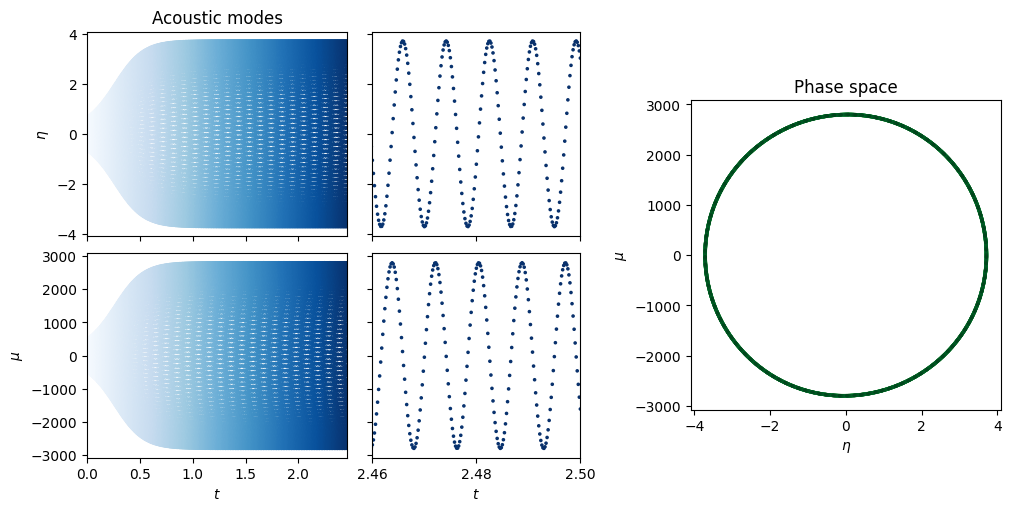

In [7]:
from essentials.physical_models import VdP
rng = np.random.default_rng(0)

dt_t = 2e-4
true_params = dict(dt=dt_t,
                   psi0=rng.random(2))

# Initialize model
true_case = VdP(**true_params)

# Forecast model

t_max = 2.5
psi, t = true_case.time_integrate(int(t_max / true_case.dt))
true_case.update_history(psi, t)

# Visualize model
fig1 = plt.figure(figsize=(10, 5), layout="constrained")
sub_fig1 = fig1.subfigures(1, 2, width_ratios=[1.5, 1])
axs = sub_fig1[0].subplots(2, 2, sharex='col', sharey='row', width_ratios=[1, 0.8])
Nt_zoom = int(true_case.t_CR / true_case.dt)
xlims = [[true_case.hist_t[0], true_case.hist_t[-1]-true_case.t_CR], [true_case.hist_t[-1]-true_case.t_CR, true_case.hist_t[-1]]]
for axs_, xl, tl in zip([axs[:, 0], axs[:, 1]], xlims, ['Acoustic modes', '']):
    for ii, ax, lbl in zip([0, 1], axs_, true_case.state_labels):
        ax.scatter(true_case.hist_t, true_case.hist[:, ii], c=true_case.hist_t, cmap='Blues', s=10, marker='.')
        if xl == xlims[0]:
            ax.set(ylabel=lbl)
    axs_[-1].set(xlabel='$t$', xlim=xl)
    axs_[0].set_title(tl)
ax = sub_fig1[1].subplots(1, 1)
ax.set_title('Phase space')
Nt_transient = int(true_case.t_transient // true_case.dt)
ax.scatter(true_case.hist[-Nt_transient:, 0], true_case.hist[-Nt_transient:, 1], c=true_case.hist_t[-Nt_transient:], cmap='Greens', s=10, marker='.')
ax.set(xlabel=true_case.state_labels[0], ylabel=true_case.state_labels[1])
ax.set_aspect(1. / ax.get_data_ratio())


plt.show()

### 2) Sample observations from the truth

In [8]:
from essentials.create import create_noisy_signal

# Retrieve observables
d_true = true_case.get_observable_hist()
t_true = true_case.hist_t

std_obs = 0.2
noise_type = 'gaussian, additive'
d_raw = create_noisy_signal(d_true, noise_level=std_obs, noise_type=noise_type)


# Draw data points from raw data
Nt_obs = 30 # time steps between analyses
t_start, t_stop = .5, 1. # start and end of assimilation

obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + Nt_obs, Nt_obs, dtype=int)
d_obs, t_obs = d_raw[obs_idx], t_true[obs_idx]

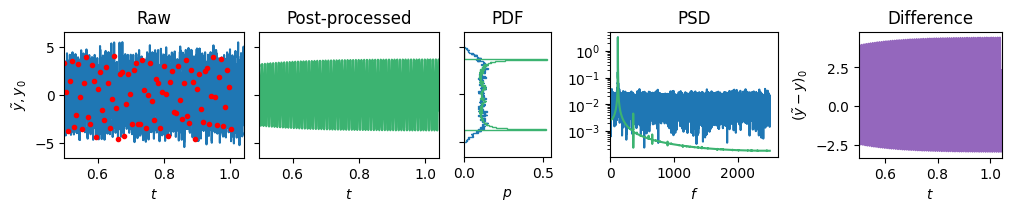

In [9]:
# Visualize the truth and observations
from essentials.plotResults import plot_truth
plot_truth(model=VdP, y_raw=d_raw, y_true=d_true, t=t_true, dt=dt_t, 
           y_obs=d_obs, t_obs=t_obs)

### 3) Create forecast ensemble

In [10]:
from essentials.create import create_ensemble

alpha0 = dict(zeta=(50., 70.), 
              )

forecast_params = dict(model=VdP,      
                       dt=dt_t,             
                       m=10,               # Number of ensemble members
                       std_psi=0.2,        # Initial uncertainty in the state
                       std_a=alpha0,       # Initial uncertainty in the parameters
                       )

ensemble = create_ensemble(**forecast_params)


### 3) Apply data assimilation

In [11]:

rng = np.random.default_rng(0)


filter_ens = ensemble.copy()
# Define measurement error covariance matrix
Cdd = np.diag((1.* np.ones(filter_ens.Nq))) ** 2


# inflation = 1.01
# ----------------------------------------------------------------------------

for d, t_d in zip(d_obs, t_obs):
    # Parallel forecast to next observation
    Nt = int(np.round((t_d - filter_ens.get_current_time) / filter_ens.dt))
    psi, t = filter_ens.time_integrate(Nt)
    filter_ens.update_history(psi, t) 
    
    # Perform assimilation 
    Aa = EnKF(filter_ens, d, Cdd)  # Analysis step

    # Aa_m = np.mean(Aa, axis=-1, keepdims=True)
    # Aa = Aa_m + inflation * (Aa - Aa_m)
    
    # Update the initial condition for the next forecast
    filter_ens.update_history(Aa[:-filter_ens.Nq, :], update_last_state=True)
    
# ----------------------------------------------------------------------------

filter_ens.close() # closes the parallel pools


/home/eidf079/eidf079/anovoa-ai4nz/codes/real-time-bias-aware-DA/venv/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


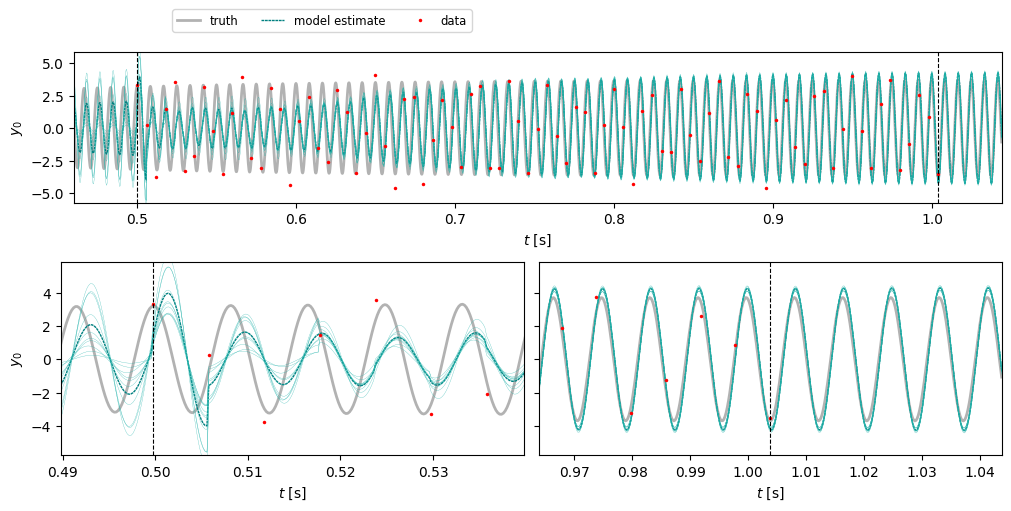

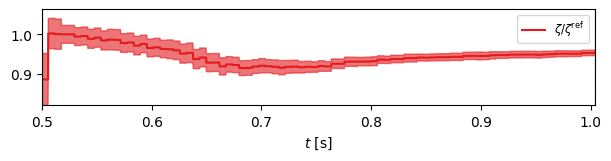

In [12]:
from essentials.plotResults import plot_timeseries, plot_parameters
true_args = dict(y_raw=d_raw, y_true=d_true, t=t_true, dt=dt_t, t_obs=t_obs, y_obs=d_obs, dt_obs=Nt_obs * dt_t)

ens = filter_ens.copy()

#Forecast the ensemble further without assimilation
Nt_extra = int(ens.t_CR / ens.dt) 

psi, t = ens.time_integrate(Nt_extra, averaged=False)
ens.update_history(psi, t)

plot_timeseries(ens, true_args, plot_ensemble_members=True)
plot_parameters(ens, true_args, reference_p=true_case.alpha0)




<br />

___


### Exercises


<em> 
<font color=#7CB9E8> How would you expect the solution to change if we decrease/increase the ensemble size? 

<font color=#7CB9E8> How would you expect the solution to change if we decrease/increase the observation noise?
</em>

___
